In [125]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os
from astropy.io import fits

In [50]:
ILC_data = np.real(np.load("train_data/ILC_MW_Map_R0000_0.npy"))

In [65]:
np.concatenate([ILC_data, ILC_data], axis=0)

array([[-6.73026205e-05, -6.73405227e-05, -6.73683029e-05, ...,
        -4.79418009e-06, -4.91596741e-06, -5.03843136e-06],
       [-1.10264873e-04, -1.10563304e-04, -1.10824114e-04, ...,
         1.72649381e-05,  1.60236551e-05,  1.47638053e-05],
       [-8.80092439e-05, -8.83807072e-05, -8.87181500e-05, ...,
         3.17091382e-05,  2.94987487e-05,  2.72337545e-05],
       ...,
       [ 3.76870906e-05,  3.80706548e-05,  3.84764229e-05, ...,
         7.92433622e-05,  8.00178971e-05,  8.08078606e-05],
       [ 9.93400566e-05,  9.95328737e-05,  9.97212636e-05, ...,
         7.92913435e-05,  7.90343694e-05,  7.87668578e-05],
       [ 7.78467734e-05,  7.78467734e-05,  7.78467734e-05, ...,
         7.78467734e-05,  7.78467734e-05,  7.78467734e-05]])

(256, 256)
(256, 256)


(256, 511)

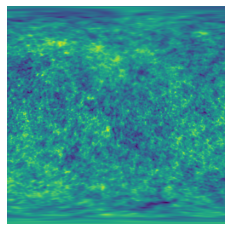

In [68]:
ILC_data_Left = ILC_data[:,0:256]
ILC_data_Right = np.concatenate([ILC_data[:,256:],ILC_data_Left[:,0:1]], axis=1)
print(ILC_data_Left.shape)
print(ILC_data_Right.shape)
plt.imshow(np.real(ILC_data_Left))
plt.axis("off")
np.load("train_data/ILC_MW_Map_R0000_0.npy").shape

(-0.5, 255.5, 255.5, -0.5)

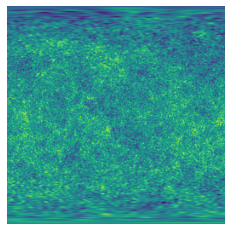

In [28]:
plt.imshow(np.real(np.load("all_masks/CMB_MW_Pix_Map_Mask_R0000.npy"))[:,0:256])
plt.axis("off")

In [156]:
def hp_pix_2_mw_pix(hp_pix, lmax):
    mw_pix = np.real(s2fft.inverse(hp_alm_2_mw_alm(hp.map2alm(hp_pix, lmax-1),lmax),lmax))
    return mw_pix

def hp_map_2_hp_alm(healpix_map, L_max):
    hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)
    return hp_alm

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm



def read_healpix_map(CMB_map_path, frequency = None, plot = False):
    original_healpix_map = hp.read_map(CMB_map_path)
    # if frequency == "545":
    #     original_healpix_map = original_healpix_map/58.0356
    # if frequency == "857":
    #     original_healpix_map = original_healpix_map/2.2681
    
    if plot:
        hp.mollview(
            original_healpix_map,
            coord=["G"],
            title="Full Sky CMB",
            unit=r"$μ$K",
            # min=-300,
            # max=300,
        )
        plt.show()
    return original_healpix_map

# Convert arcminutes to radians
def arcmin_to_radians(arcmin):
    return np.radians(arcmin / 60)

def process_map(map_data, lmax, nside):
    """
    Processes a Healpix map by converting it to spherical harmonics and back,
    and reducing the resolution.
    
    Args:
        map_data (numpy.ndarray): Input map data.
        lmax (int): Maximum multipole moment for spherical harmonics.
        nside (int): Desired nside resolution for the output map.
        
    Returns:
        numpy.ndarray: Processed map data.
    """
    alm = hp.map2alm(map_data, lmax=lmax)
    processed_map = hp.alm2map(alm, nside=nside)
    return processed_map, alm

def save_map(map_data,templete, frequency, lmax, realization):
    """
    Saves the processed map to a file with a specific naming convention.
    
    Args:
        map_data (numpy.ndarray): Map data to be saved.
        map_type (str): Type of the map (e.g., "CMB", "Synchrotron", "Noise", "CSN").
        frequency (str): Frequency identifier.
        lmax (int): Maximum multipole moment used in processing.
        realization (str): Realization identifier.
    """
    # filename = f"train/{map_type}_HP_Map_F{frequency}_L{lmax}_R{realization}.fits"
    # hp.mollview(map_data, coord=["G"], title=f"{map_type} Map" +f"F {frequency}", unit=r"$μ$K")
    # plot
    
    file_name = templete.format(frequency = frequency, lmax = lmax, realization = realization)
    np.save(file_name, map_data)
    # hp.write_map(filename, map_data,dtype="float64", overwrite=True)
    print(f"Map saved to {file_name}")






def map_subtract(map1_path, map2_path, operation = "Signal_Free", lmax = 256):

    # if hp_map1_path[-3:] == "npy":
    #     map1 = np.load(hp_map1_path)
    # else:
    #     map1 = read_healpix_map(hp_map1_path)
    
    # if hp_map2_path[-3:] == "npy":
    #     map1 = np.load(hp_map1_path)
    # else:
    #     map1 = read_healpix_map(hp_map1_path)
    if operation == "Signal_Free":
        map1 = hp_pix_2_mw_pix(read_healpix_map(map1_path), lmax)
        map2 = np.real(np.load((map2_path)))
    elif operation == "CMB_Residual":
        map1 = np.real(np.load((map1_path)))
        map2 = hp_pix_2_mw_pix(read_healpix_map(map2_path), lmax)
    
    # if format == "healpix":
    #     map1 = read_healpix_map(map1)
    #     map2 = read_healpix_map(map2)
    
    # if return_format == "MW":
    #     map1 = hp_pix_2_mw_pix(map1, lmax)
    #     map2 = hp_pix_2_mw_pix(map2, lmax)

    return (map1 - map2)



def prepare_data(frequencies, realizations, desired_lmax, directory="CMB_total"):
    """
    Processes and saves the CMB, Synchrotron, and Noise maps for all specified
    frequencies and realizations, then combines them.
    
    Args:
        frequencies (list): List of frequency identifiers.
        realizations (list): List of realization identifiers.
        lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """

    path =  "../CMB_total/CMB_HP_Map_F030_L256_R0000.fits"

    for realization in realizations:
        realziaiton_str = str(realization).zfill(4)
        print(f"Processing realization {realziaiton_str}")
        ILC_path = f"../../ILC/synthesized_ILC_MW_maps/ILC_MW_Map_R{realziaiton_str}_0.npy"
        
        all_frequneices = []
        for frequency in frequencies:
            print(f"Processing frequency {frequency}")
            # code/U-Net/data/train_data/CMB_Free_MW_Map_F030_L256_R0000.npy
            # /home/max/CMB_plot/code/U-Net/data/train_data/CMB_Free_MW_Map_F030_L256_R0000.npy
            CMB_free = f"train_data/CMB_Free_MW_Map_F9_L{desired_lmax}_R{realziaiton_str}.npy"
            if os.path.exists(CMB_free):
                print(f"File {CMB_free} already exists. Skipping download.")
                continue
            
            CSN_path =  f"../../CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realziaiton_str}.fits"
            signal_free_map = map_subtract(CSN_path,ILC_path, operation = "Signal_Free", lmax = desired_lmax)
            all_frequneices.append(signal_free_map[:,0:256])
        CMB_free_templete = "train_data/CMB_Free_MW_Map_F{frequency}_L{lmax}_R{realization}.npy"
        save_map(all_frequneices, CMB_free_templete, "9", desired_lmax, f"{realziaiton_str}")
            
        CMB_residual_path = f"train_masks/CMB_residual_MW_Map_F100_L{desired_lmax}_R{realziaiton_str}.npy"
        if os.path.exists(CMB_residual_path):
            print(f"File {CMB_residual_path} already exists. Skipping download.")
            continue
        # Create Mask: True CMB residual 
        CMB_path =  f"../../CMB_total/CMB_HP_Map_F100_L{desired_lmax}_R{realziaiton_str}.fits"
        CMB_residual = map_subtract(ILC_path, CMB_path, "CMB_Residual", lmax = desired_lmax)
        CMB_free_templete = "train_masks/CMB_Residual_MW_Map_F{frequency}_L{lmax}_R{realization}.npy"
        save_map(CMB_residual[:,0:256], CMB_free_templete, "100", desired_lmax, f"{realziaiton_str}")

            

# Define frequencies and realizations
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
# frequencies = ["030", "044"]
# frequencies = ["100"]
realizations = list(range(10))  # Realizations from 0 to 9

# Example usage with user-defined lmax
prepare_data(frequencies, realizations, desired_lmax=256)


Processing realization 0000
Processing frequency 030
Processing frequency 044
Processing frequency 070
Processing frequency 100
Processing frequency 143
Processing frequency 217
Processing frequency 353
Processing frequency 545
Processing frequency 857
Map saved to train_data/CMB_Free_MW_Map_F9_L256_R0000.npy
Map saved to train_masks/CMB_Residual_MW_Map_F100_L256_R0000.npy
Processing realization 0001
Processing frequency 030
Processing frequency 044
Processing frequency 070
Processing frequency 100
Processing frequency 143
Processing frequency 217
Processing frequency 353
Processing frequency 545
Processing frequency 857
Map saved to train_data/CMB_Free_MW_Map_F9_L256_R0001.npy
Map saved to train_masks/CMB_Residual_MW_Map_F100_L256_R0001.npy
Processing realization 0002
Processing frequency 030
Processing frequency 044
Processing frequency 070
Processing frequency 100
Processing frequency 143
Processing frequency 217
Processing frequency 353
Processing frequency 545
Processing frequency

In [147]:
CMB_free = "train_data/CMB_Free_MW_Map_F030_L256_R0000.npy" #f"train_data/CMB_Free_MW_Map_F{frequency}_L{desired_lmax}_R{realization}.npy"
if os.path.exists("train_data/CMB_Free_MW_Map_F030_L256_R0000.npy"):
    print(f"File {CMB_free} already exists. Skipping download.")


File train_data/CMB_Free_MW_Map_F030_L256_R0000.npy already exists. Skipping download.


In [110]:
CSN_map = hp.read_map("../../CMB_total/CMB_HP_Map_F030_L256_R0000.fits")

CSN_MW_map = hp_pix_2_mw_pix(CSN_map, 256)  

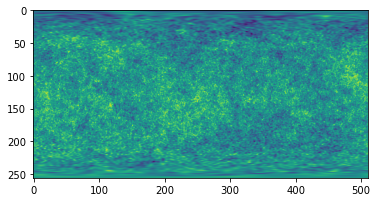

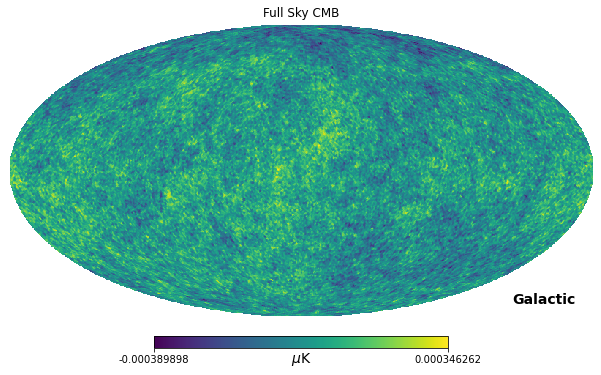

array([-1.5207962e-04, -1.6296716e-04, -1.9222577e-04, ...,
        7.5682547e-05,  6.4923865e-05, -3.3188753e-05], dtype='>f4')

In [102]:
plt.imshow(CSN_MW_map)
read_healpix_map("../../CMB_total/CMB_HP_Map_F030_L256_R0000.fits","", plot = True)

In [106]:
templete = "train_data/{map_type}_MW_Map_F{frequency}_L{lmax}_R{realization}.npy"
templete.format(map_type = "CMB", frequency = "030", lmax = 256, realization = "0000")

'train_data/CMB_MW_Map_F030_L256_R0000.npy'